In [40]:
from abc import ABC, abstractmethod
from docxtpl import DocxTemplate, InlineImage
from gtts import gTTS
from email.message import EmailMessage
from datetime import date
import smtplib
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
INVENTORY_FILE = "Sales.xlsx"
TEMPLATE_FILE = "Template.docx"

In [42]:
def error_handler(func):
    def wrapper(*args,**kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"ERROR: La funcion {func.__name__}: {e}")
            return None
    return wrapper

In [43]:
class Notifier(ABC):
    @abstractmethod
    def send_alert(self, product_name, product_stock):
        pass

class EmailNotifier(Notifier):
    @error_handler
    def send_alert(self, product_name, product_stock):
        SERVER = "smtp.gmail.com"
        PORT = 587
        EMAIL = "gip33.leap@gmail.com"
        EMAIL_PASSWORD = ""
        EMAIL_OTHER = "gip.leap@gmail.com"

        msg = EmailMessage()
        msg['Subject'] = "Reporte"
        msg["From"] = EMAIL
        msg["To"] = EMAIL_OTHER

        body = f"El producto {product_name} esta bajo en Stock, hay {product_stock} en inventario."
        msg.set_content(body)

        try:
            with smtplib.SMTP(SERVER,PORT) as smtp:
                smtp.starttls()
                smtp.login(EMAIL,EMAIL_PASSWORD)
                smtp.send_message(msg)
        except Exception as e:
            print(f"ERROR: {e}")

class VoiceNotifier(Notifier):
    @error_handler
    def send_alert(self, product_name, product_stock):
        notification = f"El producto {product_name} esta bajo en Stock, hay {product_stock} en inventario."
        tts = gTTS(text=notification,lang="es")
        tts.save(f"Reporte {product_name}.mp3")

In [44]:
class Product:
    def __init__(self, name, value, stock, min_stock, avg_sales):
        self._name = name
        self._value = value
        self._stock = stock
        self._min_stock = min_stock
        self._avg_sales = avg_sales
        self._notifiers = [EmailNotifier(),VoiceNotifier()]
    
    @property
    def stock(self):
        return self._stock
    
    @stock.setter
    def stock(self, new_stock):
        self._stock = new_stock

        if self._stock <= self._min_stock:
            self.send_critical_alert()
    
    def send_critical_alert(self):
        for notifier in self._notifiers:
            notifier.send_alert(self._name,self._stock)
    
    def days_until_depleted(self):
        return self._stock / self._avg_sales

In [45]:
class PerishableProduct(Product):
    def __init__(self, name, value, stock, min_stock, avg_sales, expiration_date):
        super().__init__(name, value, stock, min_stock, avg_sales)
        self._expiration_date = expiration_date

class ElectronicProduct(Product):
    def __init__(self, name, value, stock, min_stock, avg_sales, warranty):
        super().__init__(name, value, stock, min_stock, avg_sales)
        self._warranty = warranty

In [46]:
def generate_chart(data, filename):
    values = []
    names = []
    for index,row in data.iterrows():
        values.append(row["stock"])
        values.append(row["min_stock"])
        names.append(f"{row["product_name"]} stock")
        names.append(f"{row["product_name"]} min stock")
    plt.bar(names,values)
    plt.title("Stock Chart")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(filename)
    return filename

In [47]:
def generate_purchase_order(table,chart,filename):
    doc = DocxTemplate(TEMPLATE_FILE)
    img = InlineImage(doc,chart)
    date_now = date.today().strftime("[%d-%m-%Y]")

    context = {
        "date": date_now,
        "img": img,
        "products": table
    }

    doc.render(context)
    doc.save(filename)

    #convert(filename)

ERROR: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials 71dfb90a1353d-55cf4e44a4esm2444006e0c.6 - gsmtp')
ERROR: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials ada2fe7eead31-5e24d935fffsm2157333137.6 - gsmtp')
ERROR: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials 71dfb90a1353d-55cf516ba51sm2414577e0c.15 - gsmtp')
ERROR: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials 71dfb90a1353d-55cf518c3efsm2421938e0c.22 - gsmtp')
[{'product_name': 'product2', 'value': 30, 'stock': 8, 'min_stock': 15, 'average_sales': 6, 'days_until_depleted': 1.3333333333333333}, {'product_name': 'product3', 'value': 40, 'stock': 7, 'min_stock': 19, 'average_sales': 7,

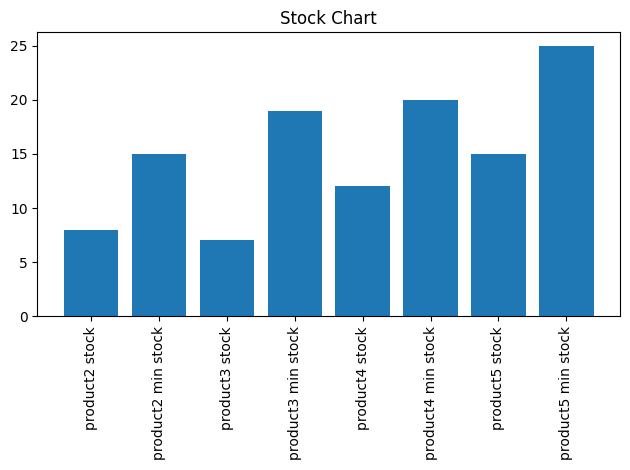

In [ ]:
def analize_inventory(filename):
    df = pd.read_excel(filename)
    critical_products = []
    for index,row in df.iterrows():
        product = Product(
            name = row["product_name"],
            value = row["value"],
            stock = row["stock"],
            min_stock = row["min_stock"],
            avg_sales = row["average_sales"]
        )

        if product.stock <= product._min_stock:
            product.send_critical_alert()
            critical_products.append(product.days_until_depleted())
    
    critical_products_data = df[df["stock"] < df["min_stock"]]
    new_df = critical_products_data.assign(days_until_depleted=critical_products)
    chart = generate_chart(new_df,"critical_products_chart.png")
    new_new_df = new_df.to_dict(orient="records")
    generate_purchase_order(new_new_df,chart,"purchase_order.docx")

analize_inventory(INVENTORY_FILE)